## PROCESS

### Santity check
- basic stats - mean, median, min, max, std
- plot histogram of sale price
- remove extreme prices (< 1000, > crazy number)
### Clean data
- check missing values, decide how to handle by column
- check duplications
- convert data types
### Exploratory data analysis
- diff scatterplots
- diff correlations
- group comparisons 
- price / sqft scale check, histogram
### Feature building
- create cleaned features for going into the model
- encode/ scale for modelling
### Train/ test split
- split data into train and test (80 train/20 test)
- X = features
- Y = sale price
### Evaluate baseline model
- MAE and RMSE
### Baseline 2: Linear Regression
- One-hot encode categorical features
- LinearRegression()
- predict on test, compute MAE and RMSE, compare against initial baseline
### Optional
- simple non-linear model - tree-based
- cluster analysis

In [819]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import math
import seaborn as sns

pd.set_option('display.float_format', '{:.3f}'.format)
df = pd.read_csv('NY-House-Dataset.csv')
# remove address values, they're not consistent with the coords
df = df.drop(columns=["BROKERTITLE","ADDRESS", "STATE", "MAIN_ADDRESS", "ADMINISTRATIVE_AREA_LEVEL_2", "SUBLOCALITY", "LOCALITY", "STREET_NAME", "LONG_NAME", 'FORMATTED_ADDRESS']).drop_duplicates()
df

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.000,1400.000,40.761,-73.974
1,Condo for sale,195000000,7,10.000,17545.000,40.766,-73.981
2,House for sale,260000,4,2.000,2015.000,40.542,-74.196
3,Condo for sale,69000,3,1.000,445.000,40.761,-73.975
4,Townhouse for sale,55000000,7,2.374,14175.000,40.767,-73.970
...,...,...,...,...,...,...,...
4796,Co-op for sale,599000,1,1.000,2184.208,40.774,-73.956
4797,Co-op for sale,245000,1,1.000,2184.208,40.733,-73.860
4798,Co-op for sale,1275000,1,1.000,2184.208,40.746,-74.003
4799,Condo for sale,598125,2,1.000,655.000,40.743,-73.873


In [820]:
# remove duplicate rows
df = df.drop_duplicates()
# # replace default sqft value wtih NaN
df.loc[np.isclose(df['PROPERTYSQFT'], 2184.208, atol=1e-3), 'PROPERTYSQFT'] = np.nan
# Compute medians per type
group_medians = df.groupby("TYPE")["PROPERTYSQFT"].transform("median")
# Fill by group median, then by overall median
df["PROPERTYSQFT"] = df["PROPERTYSQFT"].fillna(group_medians)
df["PROPERTYSQFT"] = df["PROPERTYSQFT"].fillna(df["PROPERTYSQFT"].median())
# log and winsorise SQFT and PRICE for better analysis
df['SQFT_W'] = np.log1p(winsorize(df['PROPERTYSQFT'], limits=[0.01, 0.01]))
df['PRICE_W'] = np.log1p(winsorize(df['PRICE'], limits=[0.01, 0.01]))
# fix decimal value in bath
df['BATH_clean'] = np.floor(df['BATH'])
# include reasonable bed and bath values
df = df[(df['BATH_clean'].between(1,10)) & (df['BEDS'] <= 10)]
df

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,SQFT_W,PRICE_W,BATH_clean
0,Condo for sale,315000,2,2.000,1400.000,40.761,-73.974,7.245,12.660,2.000
1,Condo for sale,195000000,7,10.000,17545.000,40.766,-73.981,9.113,16.929,10.000
2,House for sale,260000,4,2.000,2015.000,40.542,-74.196,7.609,12.468,2.000
3,Condo for sale,69000,3,1.000,445.000,40.761,-73.975,6.111,11.813,1.000
4,Townhouse for sale,55000000,7,2.374,14175.000,40.767,-73.970,9.113,16.929,2.000
...,...,...,...,...,...,...,...,...,...,...
4796,Co-op for sale,599000,1,1.000,900.000,40.774,-73.956,6.804,13.303,1.000
4797,Co-op for sale,245000,1,1.000,900.000,40.733,-73.860,6.804,12.409,1.000
4798,Co-op for sale,1275000,1,1.000,900.000,40.746,-74.003,6.804,14.058,1.000
4799,Condo for sale,598125,2,1.000,655.000,40.743,-73.873,6.486,13.302,1.000


In [538]:
from dotenv import load_dotenv
import os

load_dotenv() # reads .env file
api_key = os.getenv("GOOGLE_API_KEY")

In [ ]:
# import googlemaps
# import time

# gmaps = googlemaps.Client(key=api_key)

# features = {
#     'route': 'route'
#     , 'neighborhood': 'neighbourhood'
#     , 'political': 'sublocality'
#     , 'administrative_area_level_2': 'administrative_area'
#     }

# coords = df[['LATITUDE', 'LONGITUDE']].drop_duplicates()
# coords

# address_df = pd.DataFrame()

# # for all my coords
# for index, row in coords.iterrows():
#     lat = row['LATITUDE']
#     lon = row['LONGITUDE']

#     # call API, assign result
#     reverse_geocode_result = gmaps.reverse_geocode((lat,lon))
#     components = reverse_geocode_result[0]["address_components"]

#      # extract desired values from API
#     new_row = {
#     out_key: next(
#         (comp["long_name"] for comp in components if in_key in comp["types"])
#         , None
#     )
#     for in_key, out_key in features.items()
#     }

#     # add coords for joining later
#     new_row.update({"lat": lat, 'long': lon}) 

#     # append to df
#     address_df = pd.concat([address_df, pd.DataFrame([new_row])], ignore_index=True)

#     # cap 10 requests/ second
#     time.sleep(0.1)

# # once table is complete, export to CSV
# address_df.to_csv('correct_addresses.csv', index=False)
# print(address_df)

                                     route     neighbourhood  \
0                          Montague Street  Brooklyn Heights   
1             Frederick Douglass Boulevard              None   
2                                 Avenue P              None   
3                           Aviston Street           Oakwood   
4                        East 159th Street         Woodstock   
...                                    ...               ...   
1285                           Park Avenue              None   
1286  Adam Clayton Powell Junior Boulevard              None   
1287                      East 80th Street              None   
1288                      West 21st Street              None   
1289                        Neptune Avenue      Coney Island   

           sublocality administrative_area    lat    long  
0     Brooklyn Heights        Kings County 40.696 -73.997  
1            Manhattan     New York County 40.818 -73.946  
2             Brooklyn        Kings County 40.610 -

In [ ]:
# addresses = pd.read_csv("correct_addresses.csv")

# df["LATITUDE"] = df["LATITUDE"].round(3)
# df["LONGITUDE"] = df["LONGITUDE"].round(3)

# addresses = addresses.drop(columns=["Unnamed: 0", "route", "neighbourhood"]).drop_duplicates()
# addresses["LATITUDE"] = addresses["lat"].round(3)
# addresses["LONGITUDE"] = addresses["long"].round(3)

# addresses_dedup = (
#     addresses
#     .sort_values(["LATITUDE", "LONGITUDE"])
#     .drop_duplicates(subset=["LATITUDE", "LONGITUDE"], keep="first")
# )

# merged = df.merge(addresses_dedup, on=["LATITUDE", "LONGITUDE"], how="inner")

# df = merged
# df = df.drop(columns=['lat','long']).drop_duplicates()
# df.to_csv('final_house_prices.csv')

In [824]:
df = pd.read_csv('final_house_prices.csv').drop(columns=['Unnamed: 0','LATITUDE','LONGITUDE','PRICE'])
df

,TYPE,BEDS,BATH,PROPERTYSQFT,SQFT_W,PRICE_W,BATH_clean,sublocality,administrative_area
0,Condo for sale,2,2.000,1400.000,7.245,12.660,2.000,Manhattan,New York County
1,Condo for sale,7,10.000,17545.000,9.113,16.929,10.000,Manhattan,New York County
2,House for sale,4,2.000,2015.000,7.609,12.468,2.000,Woodrow,Richmond County
3,Condo for sale,3,1.000,445.000,6.111,11.813,1.000,Manhattan,New York County
4,Townhouse for sale,7,2.374,14175.000,9.113,16.929,2.000,Manhattan,New York County
...,...,...,...,...,...,...,...,...,...
4489,Co-op for sale,1,1.000,900.000,6.804,13.303,1.000,Manhattan,New York County
4490,Co-op for sale,1,1.000,900.000,6.804,12.409,1.000,Rego Park,Queens County
4491,Co-op for sale,1,1.000,900.000,6.804,14.058,1.000,Manhattan,New York County
4492,Condo for sale,2,1.000,655.000,6.486,13.302,1.000,Flushing,Queens County


In [ ]:
n_df = df.select_dtypes(include='number')
cv = n_df.std() / n_df.mean()
print (cv)

PRICE          13.792
BEDS            0.563
BATH            0.612
PROPERTYSQFT    1.149
LATITUDE        0.002
LONGITUDE      -0.001
SQFT_W          0.082
PRICE_W         0.072
BATH_clean      0.619
dtype: float64


In [767]:
sk_df = df.select_dtypes(include='number')
skew_lvl = sk_df.skew()
kurt_lvl = sk_df.kurt()
print (skew_lvl)
print (kurt_lvl)

PRICE               64.801
BEDS                 1.128
BATH                 1.854
PROPERTYSQFT        13.912
LATITUDE            -0.093
LONGITUDE           -0.385
SQFT_W               0.599
PRICE_W              0.824
BATH_clean           1.902
PRICE_W_BY_SQFT_W    0.824
dtype: float64
PRICE               4290.183
BEDS                   1.385
BATH                   4.908
PROPERTYSQFT         330.286
LATITUDE              -0.570
LONGITUDE              0.400
SQFT_W                -0.040
PRICE_W                0.923
BATH_clean             5.018
PRICE_W_BY_SQFT_W      1.638
dtype: float64


<Axes: xlabel='BATH_clean'>

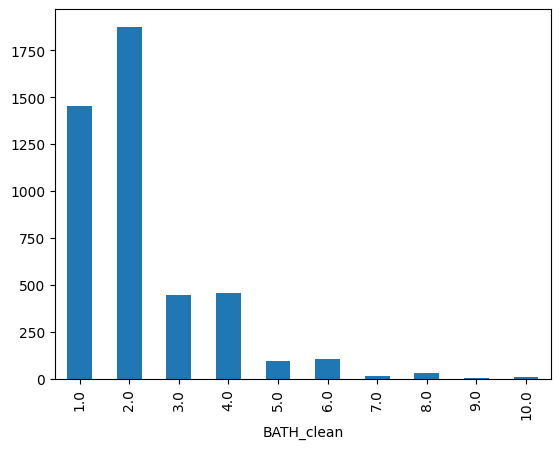

In [769]:
df['BATH_clean'].value_counts().sort_index().plot(kind='bar')

<Axes: >

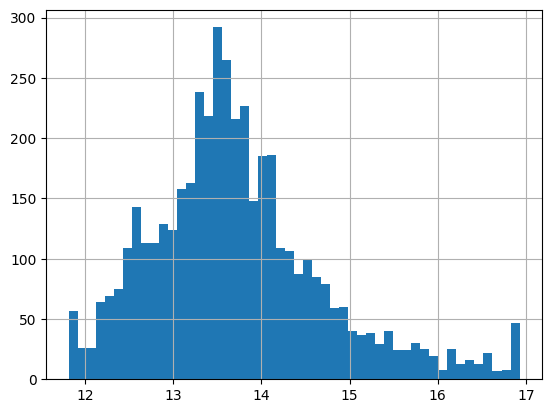

In [771]:
df['PRICE_W'].hist(bins=50)

<Axes: >

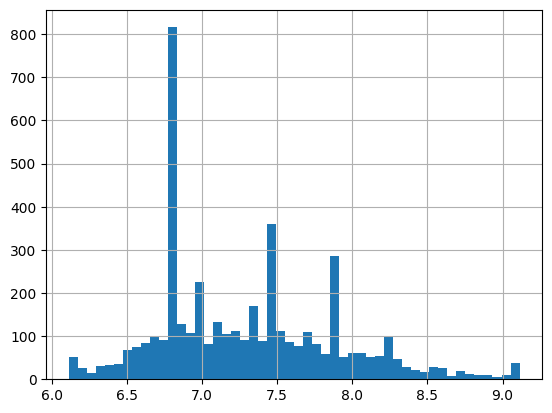

In [773]:
df['SQFT_W'].hist(bins=50)

<Axes: xlabel='TYPE'>

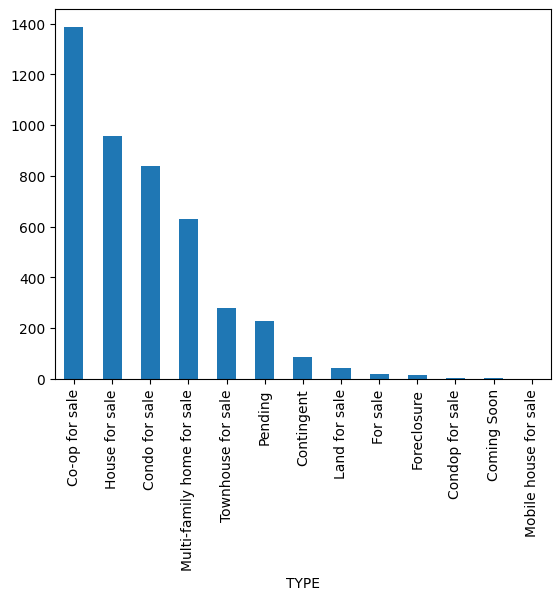

In [775]:
df.groupby('TYPE')['PRICE_W'].count().sort_values(ascending=False).plot(kind='bar')

In [825]:
# encoding etc
# TYPE
counts = df['TYPE'].value_counts()
rare = counts[counts < 49].index
df['TYPE_clean'] = df['TYPE'].replace(rare, 'Other')
mean_price = df.groupby('TYPE_clean')['PRICE_W'].mean()
df['TYPE_enc'] = df['TYPE_clean'].map(mean_price)

# BATH
df['BATH_clean'] = df['BATH_clean'].astype(str)
df.loc[df['BATH'] > 6, 'BATH_clean'] = '7+'
mean_price = df.groupby('BATH_clean')['PRICE_W'].mean()
df['BATH_enc'] = df['BATH_clean'].map(mean_price)

# BED
df['BEDS_clean'] = df['BEDS'].astype(str)
df.loc[df['BEDS'] > 6, 'BEDS_clean'] = '7+'
mean_price = df.groupby('BEDS_clean')['PRICE_W'].mean()
df['BEDS_enc'] = df['BEDS_clean'].map(mean_price)

# TYPE
counts = df['TYPE'].value_counts()
rare = counts[counts < 49].index
df['TYPE_clean'] = df['TYPE'].replace(rare, 'Other')
mean_price = df.groupby('TYPE_clean')['PRICE_W'].mean()
df['TYPE_enc'] = df['TYPE_clean'].map(mean_price)

# sublocality grouped
top = df["sublocality"].value_counts().nlargest(25).index
df["sublocality_grouped"] = df["sublocality"].where(df["sublocality"].isin(top), "Other")

# sublocality
mean_price_by_sub = df.groupby("sublocality")["PRICE_W"].mean()
df["sublocality_enc"] = df["sublocality"].map(mean_price_by_sub)
df

# administrative_area
mean_price_by_ad_area = df.groupby("administrative_area")["PRICE_W"].mean()
df["administrative_area_enc"] = df["administrative_area"].map(mean_price_by_ad_area)
df

,TYPE,BEDS,BATH,PROPERTYSQFT,SQFT_W,PRICE_W,BATH_clean,sublocality,administrative_area,TYPE_clean,TYPE_enc,BATH_enc,BEDS_clean,BEDS_enc,sublocality_grouped,sublocality_enc,administrative_area_enc
0,Condo for sale,2,2.000,1400.000,7.245,12.660,2.0,Manhattan,New York County,Condo for sale,13.977,13.846,2,13.494,Manhattan,14.393,14.395
1,Condo for sale,7,10.000,17545.000,9.113,16.929,7+,Manhattan,New York County,Condo for sale,13.977,15.682,7+,14.660,Manhattan,14.393,14.395
2,House for sale,4,2.000,2015.000,7.609,12.468,2.0,Woodrow,Richmond County,House for sale,13.799,13.846,4,14.220,Other,13.901,13.494
3,Condo for sale,3,1.000,445.000,6.111,11.813,1.0,Manhattan,New York County,Condo for sale,13.977,12.906,3,13.660,Manhattan,14.393,14.395
4,Townhouse for sale,7,2.374,14175.000,9.113,16.929,2.0,Manhattan,New York County,Townhouse for sale,14.961,13.846,7+,14.660,Manhattan,14.393,14.395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,Co-op for sale,1,1.000,900.000,6.804,13.303,1.0,Manhattan,New York County,Co-op for sale,13.185,12.906,1,12.950,Manhattan,14.393,14.395
4490,Co-op for sale,1,1.000,900.000,6.804,12.409,1.0,Rego Park,Queens County,Co-op for sale,13.185,12.906,1,12.950,Rego Park,12.849,13.334
4491,Co-op for sale,1,1.000,900.000,6.804,14.058,1.0,Manhattan,New York County,Co-op for sale,13.185,12.906,1,12.950,Manhattan,14.393,14.395
4492,Condo for sale,2,1.000,655.000,6.486,13.302,1.0,Flushing,Queens County,Condo for sale,13.977,12.906,2,13.494,Flushing,13.672,13.334


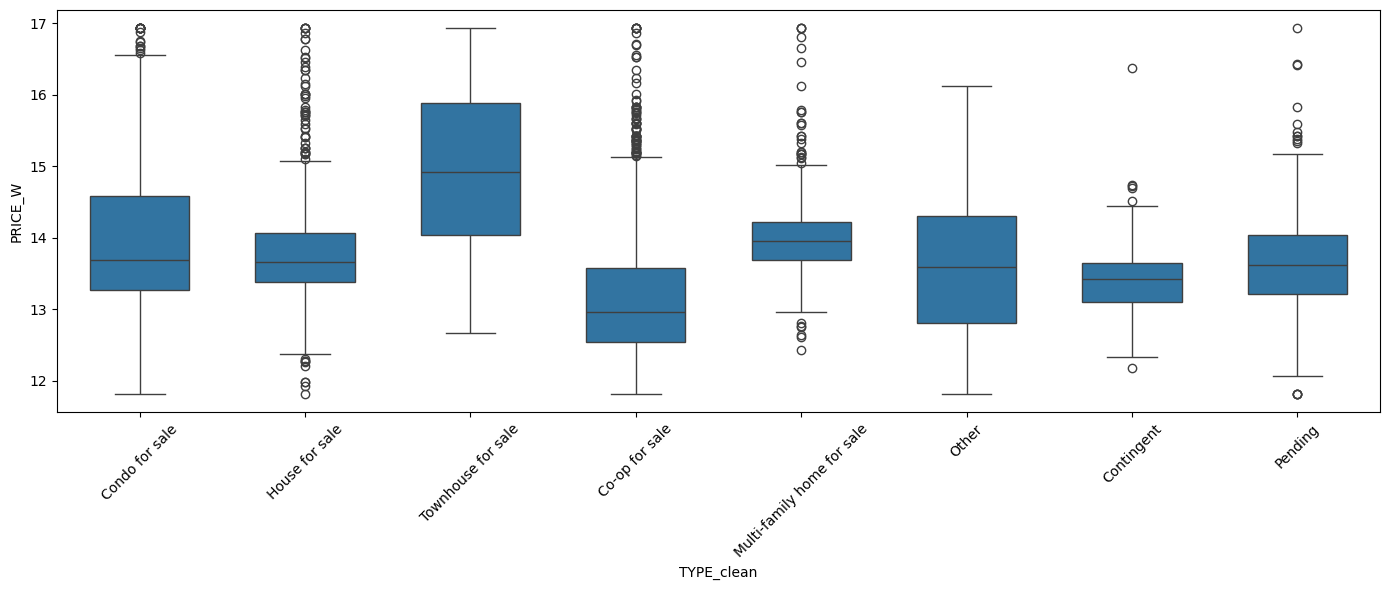

In [778]:
plt.figure(figsize=(14,6))
sns.boxplot(x='TYPE_clean', y='PRICE_W', data=df, width=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

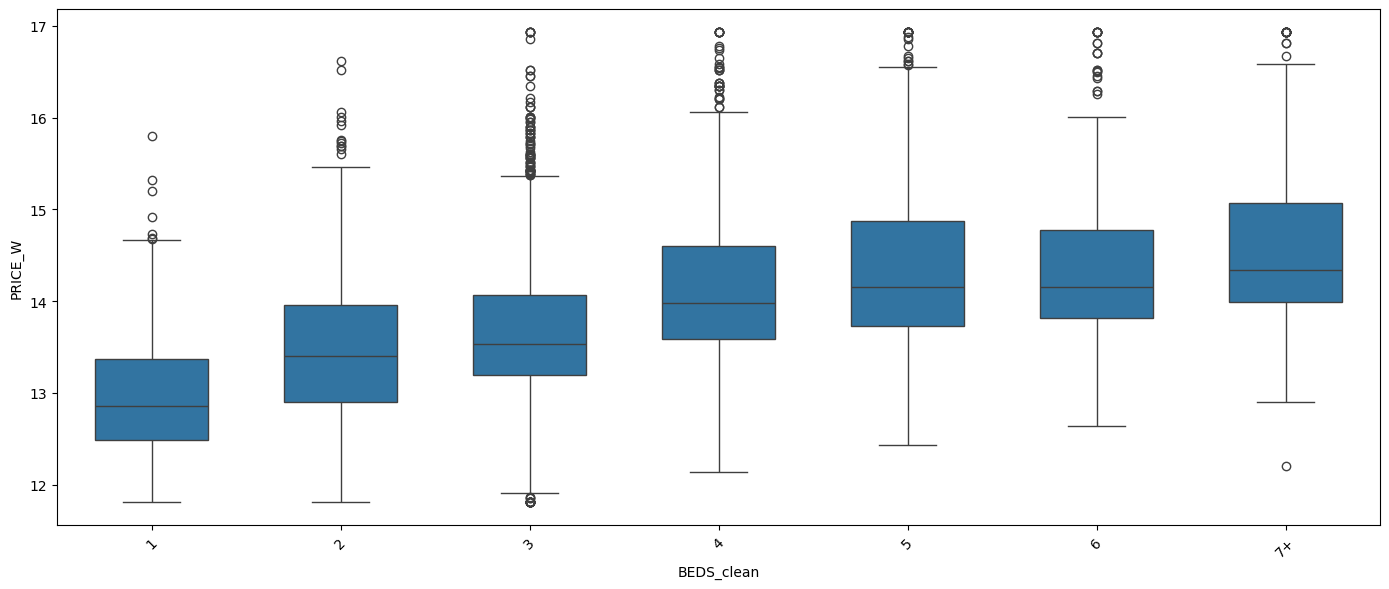

In [779]:
order = (
    df.loc[df['BEDS_clean'] != '7+', 'BEDS_clean']
    .astype(int)
    .sort_values()
    .unique()
    .tolist()
    + ['7+']
)

plt.figure(figsize=(14,6))
sns.boxplot(x='BEDS_clean', y='PRICE_W', data=df, width=0.6, order=order)
plt.xticks(rotation=45)
plt.tight_layout()

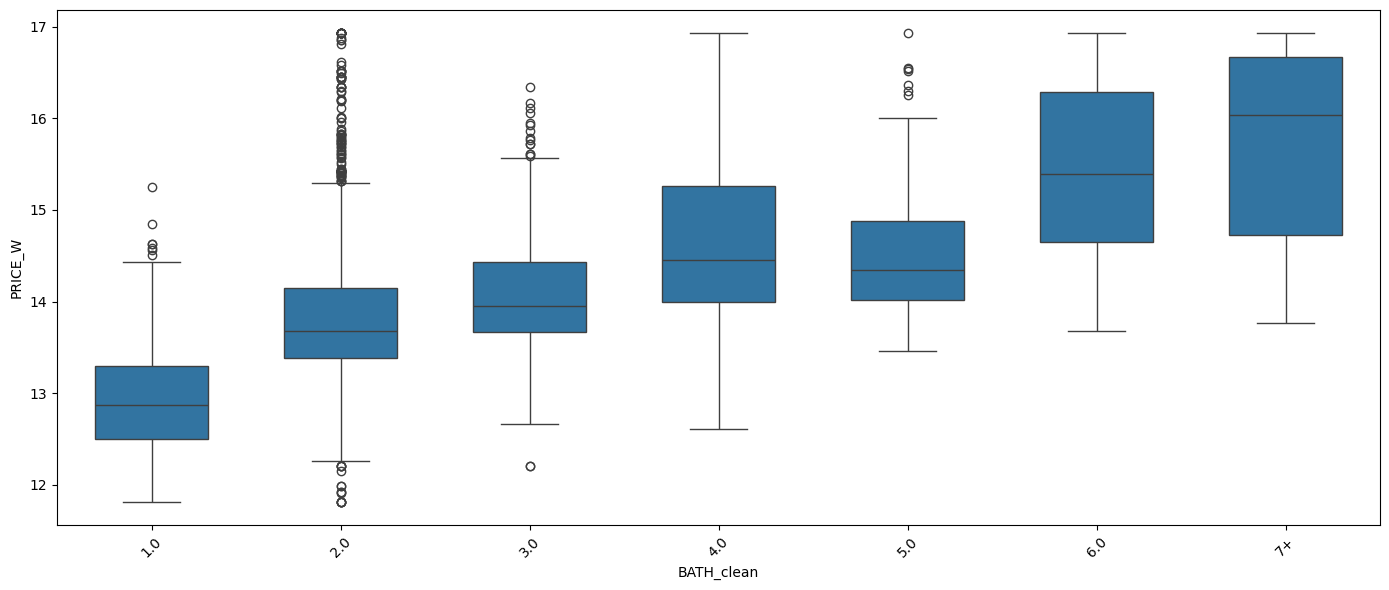

In [780]:
order = (
    df.loc[df['BATH_clean'] != '7+', 'BATH_clean']
    .astype(float)
    .sort_values()
    .unique()
    .tolist()
    + ['7+']
)

plt.figure(figsize=(14,6))
sns.boxplot(x='BATH_clean', y='PRICE_W', data=df, width=0.6, order=order)
plt.xticks(rotation=45)
plt.tight_layout()

In [397]:
# ANOVA (Analysis of Variance)
from scipy.stats import f_oneway

groups = [g['PRICE_W'].values for _, g in df.groupby('TYPE_clean')]
f_stat, p_val = f_oneway(*groups)
print(math.floor(f_stat), p_val)

175 6.495193950363423e-231


In [398]:
# Kruskal-Wallis statistic

from scipy.stats import kruskal
groups = [g['PRICE_W'] for _, g in df.groupby('TYPE_clean')]
stat, p = kruskal(*groups)
print(stat, p)

1054.9380944689065 1.6183744341720317e-223


In [ ]:
# posthoc dunn
import scikit_posthocs as sp
sp.posthoc_dunn(df, val_col='PRICE_W', group_col='TYPE_clean', p_adjust='bonferroni')

,Co-op for sale,Condo for sale,Contingent,House for sale,Multi-family home for sale,Other,Pending,Townhouse for sale
Co-op for sale,1.000,0.000,0.273,0.000,0.000,0.000,0.000,0.000
Condo for sale,0.000,1.000,0.000,1.000,0.000,0.247,0.107,0.000
Contingent,0.273,0.000,1.000,0.000,0.000,1.000,0.247,0.000
House for sale,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000
Multi-family home for sale,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
Other,0.000,0.247,1.000,1.000,0.000,1.000,1.000,0.000
Pending,0.000,0.107,0.247,1.000,0.000,1.000,1.000,0.000
Townhouse for sale,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


<Axes: >

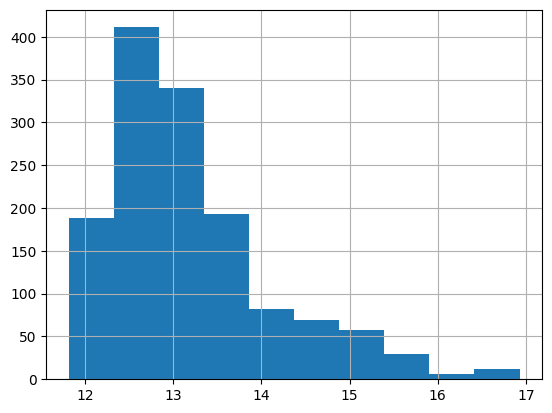

In [781]:
df[df['TYPE_clean'] == 'Co-op for sale']['PRICE_W'].hist(bins=10)

In [782]:
# Normality per group
from scipy.stats import shapiro, levene
for k, g in df.groupby('TYPE_clean'):
    print(k, shapiro(g['PRICE_W']).pvalue)

# Equal variance test
levene(*[g['PRICE_W'].values for _, g in df.groupby('TYPE_clean')])

Co-op for sale 9.667872675634236e-29
Condo for sale 4.584851106033559e-17
Contingent 4.736353539007385e-06
House for sale 1.3054921265009032e-25
Multi-family home for sale 3.3204544172500714e-20
Other 0.1822396994959288
Pending 3.899749304271585e-05
Townhouse for sale 2.6101171761455294e-06


LeveneResult(statistic=np.float64(50.259130508134426), pvalue=np.float64(2.9441379170918754e-69))

In [783]:
df[['PRICE_W', 'BATH_enc']].corr(method='spearman')

,PRICE_W,BATH_enc
PRICE_W,1.000,0.704
BATH_enc,0.704,1.000


In [784]:
df[['PRICE_W', 'BEDS_enc']].corr(method='spearman')

,PRICE_W,BEDS_enc
PRICE_W,1.000,0.534
BEDS_enc,0.534,1.000


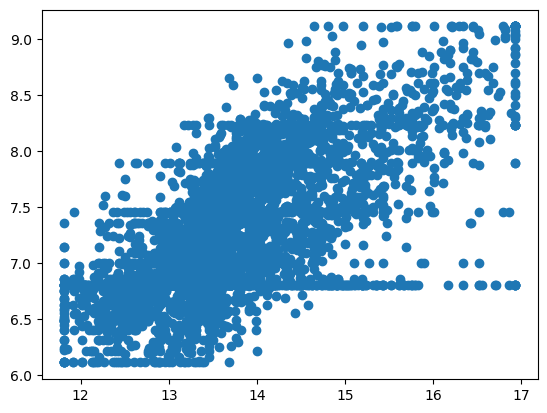

In [813]:
df[['sublocality_value','PRICE_W']].corr(method='spearman')

,sublocality_value,PRICE_W
sublocality_value,1.000,0.553
PRICE_W,0.553,1.000


In [812]:
df[['administrative_area_value','PRICE_W']].corr(method='spearman')

,administrative_area_value,PRICE_W
administrative_area_value,1.000,0.397
PRICE_W,0.397,1.000


<Axes: xlabel='sublocality_grouped'>

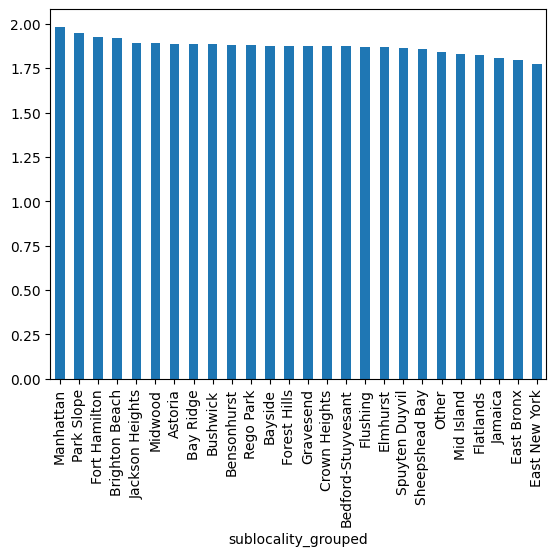

In [806]:
df.groupby("sublocality_grouped")["PRICE_W_BY_SQFT_W"].mean().sort_values(ascending=False).plot(kind='bar')

In [834]:
# prepare data for 
features_df = df.copy()
features_df = features_df.drop(columns=['TYPE','BEDS','BATH','PROPERTYSQFT','BATH_clean','sublocality','administrative_area','TYPE_clean','BEDS_clean','sublocality_grouped'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df[['SQFT_W', 'TYPE_enc', 'BATH_enc', 'BEDS_enc', 'sublocality_enc', 'administrative_area_enc']])
X_scaled

array([[-0.08273486,  0.5418294 ,  0.17425813, -0.45582194,  1.19051816,
         1.48826256],
       [ 3.04059121,  0.5418294 ,  2.87308727,  1.81942926,  1.19051816,
         1.48826256],
       [ 0.52561475,  0.15514287,  0.17425813,  0.96034136,  0.31035589,
        -0.5261801 ],
       ...,
       [-0.82064675, -1.17679797, -1.20807424, -1.51620047,  1.19051816,
         1.48826256],
       [-1.35112479,  0.5418294 , -1.20807424, -0.45582194, -0.0988326 ,
        -0.88239711],
       [-1.12504733, -1.17679797, -1.20807424, -1.51620047, -1.25784982,
         0.06875272]])